# SCI6485 Introduction to Generative Artificial Intelligence

##  Canny Edge Detection


**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**  Sabrina Osmany<br/>
**TA:**  Jiabin Wei<br/>

**DISCLAIMER**: No public reproduction of this code is allowed without the explicit consent of their authors.

<hr style="height:2pt">

---

The Canny edge detector employs a multi-stage algorithm to identify various edges in images. It was introduced by John Canny in 1986.
There are five steps in Canny edge detection:
The Canny edge detection algorithm is composed of 5 steps:

1. Noise reduction;
2. Gradient calculation;
3. Non-maximum suppression;
4. Threshold and Hysteresis.


In [ ]:
from imageio.v2 import imread, imsave
import cv2
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torchvision.transforms as transforms

In [ ]:
!pwd

/content


In [ ]:
mkdir class


In [ ]:
!ls

brady.jpeg  brady.jpg  class  obama.jpeg  robot.jpeg  sample_data


# 0. Prepare an image
you could upload a jpg image to the colab root directory. Here we define some functions to help you transfer images to tensors that the pytorch can process and transfer the tensor back to images so that you can visualize the result.


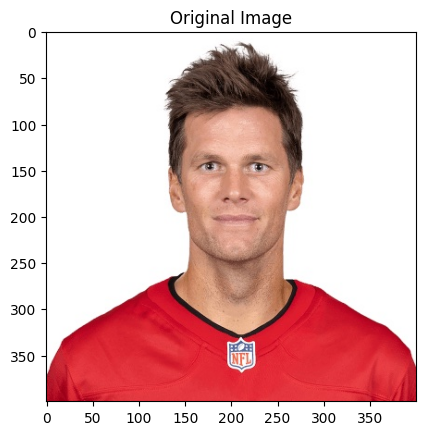

In [ ]:
# identify your device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# transform the image into a torch tensor
loader = transforms.Compose([
    transforms.ToTensor()])

def image_loader(image_path):
    image = Image.open(image_path)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    # reconvert into PIL image
    unloader = transforms.ToPILImage()
    # we clone the tensor to not do changes on it
    image = tensor.cpu().clone()
    # remove the fake batch dimension
    image = image.squeeze(0)

    if image.shape[0] == 1:
        image = unloader(image).convert('LA')
    else:
        image = unloader(image)

    plt.figure()
    plt.imshow(image)
    if title is not None:
        plt.title(title)

image = image_loader("brady.jpg")
imshow(image, title='Original Image')

# 1. Noise reduction

Canny edge detection results are highly sensitive to image noise as we will approximate the derivatives of the pixels. You would have a better sense of why we denoise the image when we introduce the the 2nd step.

One way to get rid of the noise on the image, is by applying [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) to smooth it. To do so, image convolution technique is applied with a Gaussian Kernel (3x3, 5x5, 7x7 etc…). Here we define a gaussian kernel by hand. But you could also use existing library to generate the gaussian kernel.

In [ ]:
def get_gaussian_kernel(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(-1, 1, k)
    # compute a grid distance from center
    # meshgrid essentially creates a grid of points by repeating and combining the input arrays.
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)

    # generate the distance matrix
    distance = (x ** 2 + y ** 2) ** 0.5

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi *sigma **2)

    # normalize the filter as we want to make sure the value of the channel at each pixel stay the same after applying the gaussian filter. Othewise the color will be changed.
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D

# check the gaussian kernel value
print(get_gaussian_kernel(k=5, mu=0, sigma=1, normalize=False))

[[0.05854983 0.0851895  0.09653235 0.0851895  0.05854983]
 [0.0851895  0.12394999 0.14045374 0.12394999 0.0851895 ]
 [0.09653235 0.14045374 0.15915494 0.14045374 0.09653235]
 [0.0851895  0.12394999 0.14045374 0.12394999 0.0851895 ]
 [0.05854983 0.0851895  0.09653235 0.0851895  0.05854983]]


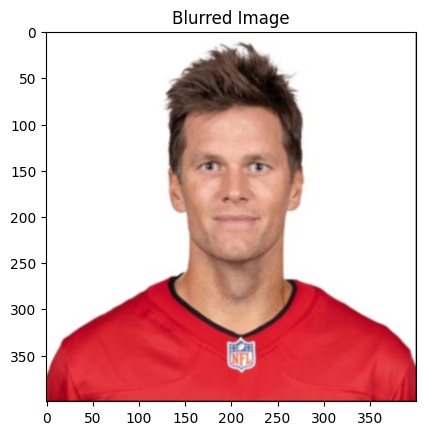

In [ ]:
# set hyperparameters for the gaussian function.
# you can change to see what will happen to your image
k_gaussian = 3 # has to be an odd number
mu = 0
sigma = 1

# batch size, channel number, height and width
B, C, H, W = image.shape

# generate a gaussian kernel with our gaussian function defined above
gaussian_2D = get_gaussian_kernel(k_gaussian, mu, sigma, normalize=True)

# create a convolutional filter
gaussian_filter = nn.Conv2d(in_channels=1,
                            out_channels=1,
                            kernel_size=k_gaussian,
                            padding=k_gaussian // 2,
                            bias=False)

# assign the gaussian kernel values to the convolutional filter
gaussian_filter.weight = nn.Parameter(torch.from_numpy(gaussian_2D).float().unsqueeze(0).unsqueeze(0))


# create an empty tensor template to save the blurred image later
blurred = torch.zeros((B, C, H, W)).to(device)

# loop through 3 channels and apply the gaussian filter to all of them
for c in range(C):
    blurred[:, c:c+1] = gaussian_filter(image[:, c:c+1])

# visualize the blurred image
imshow(blurred, title='Blurred Image')

# 2. Gradient Calculation

Edges correspond to a change of pixels’ intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y).

In this the Gradient calculation step, we will use the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) to detect the edge intensity and direction by approximating the deriviatives of pixel's intensity. You may find different ways to generate Sobel operator in python.

In [ ]:
def get_sobel_kernel(k=3):
    # get range
    range = np.linspace(-(k // 2), k // 2, k)
    # compute a grid the numerator and the axis-distances
    x, y = np.meshgrid(range, range)

    sobel_2D_numerator = x
    sobel_2D_denominator = (x ** 2 + y ** 2)

    # avoid division by zero
    sobel_2D_denominator[:, k // 2] = 1

    sobel_2D = sobel_2D_numerator / sobel_2D_denominator
    return sobel_2D

# used to calculate gradients horizontally -> detect vertical edge
print(get_sobel_kernel(k=5))

# used to calculate gradients vertically -> detect horiziontal edge
print(get_sobel_kernel(k=5).T)

[[-0.25 -0.2   0.    0.2   0.25]
 [-0.4  -0.5   0.    0.5   0.4 ]
 [-0.5  -1.    0.    1.    0.5 ]
 [-0.4  -0.5   0.    0.5   0.4 ]
 [-0.25 -0.2   0.    0.2   0.25]]
[[-0.25 -0.4  -0.5  -0.4  -0.25]
 [-0.2  -0.5  -1.   -0.5  -0.2 ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.2   0.5   1.    0.5   0.2 ]
 [ 0.25  0.4   0.5   0.4   0.25]]


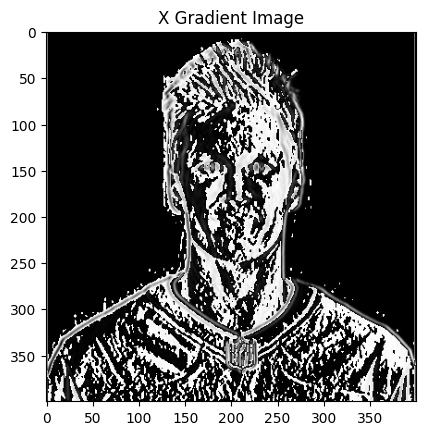

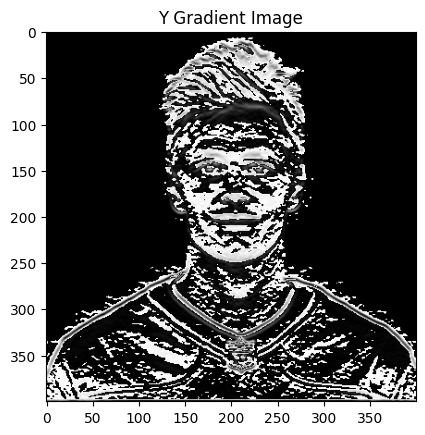

In [ ]:
k_sobel = 3

# create another convolutional filter for X sobel filter
sobel_2D = get_sobel_kernel(k_sobel)
sobel_filter_x = nn.Conv2d(in_channels=1,
                            out_channels=1,
                            kernel_size=k_sobel,
                            padding=k_sobel // 2,
                            bias=False)

# assign the x sobel filter values to the convolutional filter
sobel_filter_x.weight = nn.Parameter(torch.from_numpy(sobel_2D).float().unsqueeze(0).unsqueeze(0))

# create another convolutional filter for Y sobel filter
sobel_filter_y = nn.Conv2d(in_channels=1,
                            out_channels=1,
                            kernel_size=k_sobel,
                            padding=k_sobel // 2,
                            bias=False)

# assign the y sobel filter values to the convolutional filter
sobel_filter_y.weight = nn.Parameter(torch.from_numpy(sobel_2D.T).float().unsqueeze(0).unsqueeze(0))


# create empty tensor templates to save the x and y gradient image
grad_x = torch.zeros((B, 1, H, W)).to(device)
grad_y = torch.zeros((B, 1, H, W)).to(device)

for c in range(C):
    grad_x = grad_x + sobel_filter_x(blurred[:, c:c+1])
    grad_y = grad_y + sobel_filter_y(blurred[:, c:c+1])

grad_x = grad_x / C
grad_y = grad_y / C

# visualize the X gradient image
imshow(grad_x, title='X Gradient Image')

# # visualize the Y gradient image
imshow(grad_y, title='Y Gradient Image')


we have our gradients on both axes of our image. To detect the contours, we want to have the magnitude of our gradient. We can use the absolute-value norm or the euclidean norm.

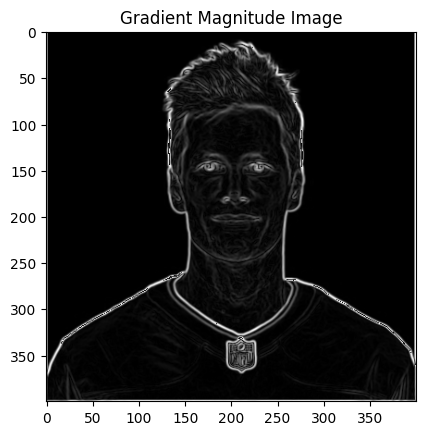

In [ ]:
# calculate the euclidean distance of the x and y gradient
grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
# calculate the orientation of the gradient
grad_orientation = torch.atan(grad_y / grad_x)
# convert to degree
grad_orientation = grad_orientation * (360 / np.pi) + 180
# keep a split by 45
grad_orientation = torch.round(grad_orientation / 45) * 45

# visualize the gradient magnitude image
imshow(grad_magnitude, title='Gradient Magnitude Image')

# # visualize the gradient orientation image
# imshow(grad_orientation, title='Gradient Orientation Image')

# 3. Non-Maximum suppression
The result is almost the expected one, but we can see that some of the edges are thick and others are thin. Non-Max Suppression step will help us mitigate the thick ones.

The principle is simple: the algorithm goes through all the points on the gradient magnitude matrix and finds the pixels with the maximum value in the edge directions. This [link](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123) has some really cool diagrams to show how non-maximum suppression works.

The non-max-suppression steps are:

- Create a matrix initialized to 0 of the same size of the original gradient magnitute matrix;
- Identify the edge direction based on the angle value from the angle matrix;
- Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;
- Return the image processed with the non-max suppression algorithm.

In [ ]:
def get_thin_kernels(start=0, end=360, step=45):
    k_thin = 3
    # increase for a while to avoid interpolation when rotating
    k_increased = k_thin + 2

    # get 0° angle directional kernel
    thin_kernel_0 = np.zeros((k_increased, k_increased))
    thin_kernel_0[k_increased // 2, k_increased // 2] = 1
    thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1

    # rotate the 0° angle directional kernel 45° to get the other ones
    thin_kernels = []
    for angle in range(start, end, step):
        (h, w) = thin_kernel_0.shape
        # get the center to not rotate around the (0, 0) coord point
        center = (w // 2, h // 2)
        # apply rotation
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
        kernel_angle_increased = cv2.warpAffine(thin_kernel_0, rotation_matrix, (w, h), cv2.INTER_NEAREST)

        # get the k=3 kernel
        kernel_angle = kernel_angle_increased[1:-1, 1:-1]
        is_diag = (abs(kernel_angle) == 1)
        kernel_angle = kernel_angle * is_diag
        thin_kernels.append(kernel_angle)

    return thin_kernels

for kernel in get_thin_kernels():
    print(kernel)


[[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0.  0.  0.]]
[[ 0. -0. -1.]
 [ 0.  1. -0.]
 [ 0.  0.  0.]]
[[ 0. -1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
[[-1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [-1.  1.  0.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [-0.  1.  0.]
 [-1. -0.  0.]]
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -1.  0.]]
[[ 0.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0. -1.]]


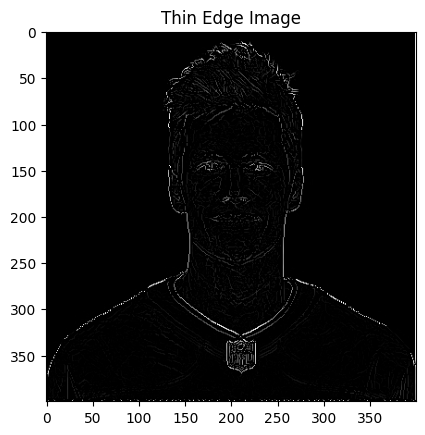

In [ ]:
thin_kernels = get_thin_kernels()
directional_kernels = np.stack(thin_kernels)

directional_filter = nn.Conv2d(in_channels=1,
                                out_channels=8,
                                kernel_size=thin_kernels[0].shape,
                                padding=thin_kernels[0].shape[-1] // 2,
                                stride=1,
                                bias=False)

# Copy the weights to the 'directional_filter' layer
with torch.no_grad():  # Disable gradient tracking for this operation
    directional_filter.weight[:, 0].copy_(torch.from_numpy(directional_kernels))

directional = directional_filter(grad_magnitude)

# get indices of positive and negative directions
positive_idx = (grad_orientation / 45) % 8
negative_idx = ((grad_orientation / 45) + 4) % 8

thin_edges = grad_magnitude.clone()

# non maximum suppression direction by direction
for pos_i in range(4):
    neg_i = pos_i + 4
    # get the oriented grad for the angle
    is_oriented_i = (positive_idx == pos_i) * 1
    is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
    pos_directional = directional[:, pos_i]
    neg_directional = directional[:, neg_i]
    selected_direction = torch.stack([pos_directional, neg_directional])

    # get the local maximum pixels for the angle
    is_max = selected_direction.min(dim=0)[0] > 0.0
    is_max = torch.unsqueeze(is_max, dim=1)

    # apply non maximum suppression
    to_remove = (is_max == 0) * 1 * (is_oriented_i) > 0
    thin_edges[to_remove] = 0.0

# visualize the thin edge image
imshow(thin_edges, title='Thin Edge Image')


# 4. Thresholds and Hysteresis

The thin edge image looks pretty good. But you may notice that some edges are strong while others are weak. Some edges are broken. We want to make sure all the edges in the final result are clear and strong. We will try to fix these issues with double thresholds and hysteresis. More information about these two methods could be found [here](https://theailearner.com/tag/non-max-suppression/).

Double thresholds:
- Low-High threshold: the pixels with an intensity higher than the threshold are set to 1 and the others to 0.
- Low-Weak and Weak-High thresholds: we set the pixels with high intensity to 1, the pixels with Low intensity to 0 and between the two thresholds we set them to 0.5. They are considered as Weak.

Hysteresis:
- based on the result from the double thresholds, we further evaluate the weak pixels with their hysteresis level and reassign them as High or Low.

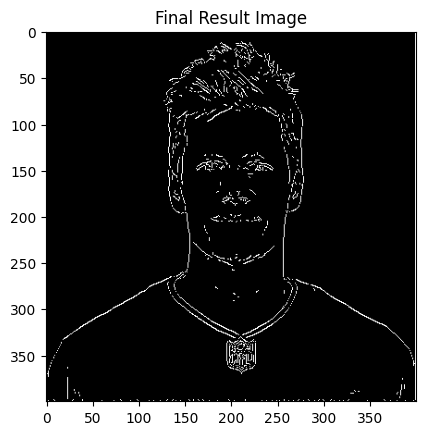

In [ ]:
# you can change these two threshold to see how the result changes
low_threshold = 0.15
high_threshold = 0.3

hysteresis_filter = np.ones((3, 3)) + 0.25
hysteresis = nn.Conv2d(in_channels=1,
                        out_channels=1,
                        kernel_size=3,
                        padding=1,
                        bias=False)

hysteresis.weight = nn.Parameter(torch.from_numpy(hysteresis_filter).float().unsqueeze(0).unsqueeze(0))

final_result = thin_edges.clone()

if low_threshold is not None:
    low = final_result > low_threshold

    if high_threshold is not None:
        high = final_result > high_threshold
        # get black/gray/white only
        final_result = low * 0.5 + high * 0.5

        # get weaks and check if they are high or not
        weak = (final_result == 0.5) * 1.0
        weak_is_high = (hysteresis(final_result) > 1) * weak
        final_result = high * 1.0 + weak_is_high * 1.0
    else:
        final_result = low * 1.0

# visualize the thin edge image
imshow(final_result, title='Final Result Image')



# Put everything together
we can put all the steps above together in and pack them as a Pytorch model.

In [ ]:
def get_gaussian_kernel(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(-1, 1, k)
    # compute a grid distance from center
    # meshgrid essentially creates a grid of points by repeating and combining the input arrays.
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)

    # generate the distance matrix
    distance = (x ** 2 + y ** 2) ** 0.5

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi *sigma **2)

    # normalize part (mathematically)
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D

def get_sobel_kernel(k=3):
    # get range
    range = np.linspace(-(k // 2), k // 2, k)
    # compute a grid the numerator and the axis-distances
    x, y = np.meshgrid(range, range)

    sobel_2D_numerator = x
    sobel_2D_denominator = (x ** 2 + y ** 2)

    # avoid division by zero
    sobel_2D_denominator[:, k // 2] = 1

    sobel_2D = sobel_2D_numerator / sobel_2D_denominator
    return sobel_2D

def get_thin_kernels(start=0, end=360, step=45):
    k_thin = 3
    # increase for a while to avoid interpolation when rotating
    k_increased = k_thin + 2

    # get 0° angle directional kernel
    thin_kernel_0 = np.zeros((k_increased, k_increased))
    thin_kernel_0[k_increased // 2, k_increased // 2] = 1
    thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1

    # rotate the 0° angle directional kernel 45° to get the other ones
    thin_kernels = []
    for angle in range(start, end, step):
        (h, w) = thin_kernel_0.shape
        # get the center to not rotate around the (0, 0) coord point
        center = (w // 2, h // 2)
        # apply rotation
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
        kernel_angle_increased = cv2.warpAffine(thin_kernel_0, rotation_matrix, (w, h), cv2.INTER_NEAREST)

        # get the k=3 kernel
        kernel_angle = kernel_angle_increased[1:-1, 1:-1]
        is_diag = (abs(kernel_angle) == 1)
        kernel_angle = kernel_angle * is_diag
        thin_kernels.append(kernel_angle)

    return thin_kernels

In [ ]:
class CannyFilter(nn.Module):
    def __init__(self,
                 k_gaussian=3,
                 mu=0,
                 sigma=1,
                 k_sobel=3,
                 low_threshold=0.15,
                 high_threshold=0.3
                 ):

        super(CannyFilter, self).__init__()

        # device
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # gaussian
        gaussian_2D = get_gaussian_kernel(k_gaussian, mu, sigma)
        self.gaussian_filter = nn.Conv2d(in_channels=1,
                                         out_channels=1,
                                         kernel_size=k_gaussian,
                                         padding=k_gaussian // 2,
                                         bias=False)

        with torch.no_grad():
            self.gaussian_filter.weight[:].copy_(torch.from_numpy(gaussian_2D))

        # sobel
        sobel_2D = get_sobel_kernel(k_sobel)
        self.sobel_filter_x = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False)
        with torch.no_grad():
            self.sobel_filter_x.weight[:].copy_(torch.from_numpy(sobel_2D))


        self.sobel_filter_y = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False)
        with torch.no_grad():
            self.sobel_filter_y.weight[:].copy_(torch.from_numpy(sobel_2D.T))


        # thin
        thin_kernels = get_thin_kernels()
        directional_kernels = np.stack(thin_kernels)

        self.directional_filter = nn.Conv2d(in_channels=1,
                                            out_channels=8,
                                            kernel_size=thin_kernels[0].shape,
                                            padding=thin_kernels[0].shape[-1] // 2,
                                            bias=False)
        with torch.no_grad():
            self.directional_filter.weight[:, 0].copy_(torch.from_numpy(directional_kernels))

        # hysteresis
        hysteresis = np.ones((3, 3)) + 0.25
        self.hysteresis = nn.Conv2d(in_channels=1,
                                    out_channels=1,
                                    kernel_size=3,
                                    padding=1,
                                    bias=False)

        with torch.no_grad():
            self.hysteresis.weight[:].copy_(torch.from_numpy(hysteresis))

        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

    def forward(self, img):
        # set the setps tensors
        B, C, H, W = img.shape
        blurred = torch.zeros((B, C, H, W)).to(self.device)
        grad_x = torch.zeros((B, 1, H, W)).to(self.device)
        grad_y = torch.zeros((B, 1, H, W)).to(self.device)
        grad_magnitude = torch.zeros((B, 1, H, W)).to(self.device)
        grad_orientation = torch.zeros((B, 1, H, W)).to(self.device)

        # gaussian
        for c in range(C):
            blurred[:, c:c+1] = self.gaussian_filter(img[:, c:c+1])

            grad_x = grad_x + self.sobel_filter_x(blurred[:, c:c+1])
            grad_y = grad_y + self.sobel_filter_y(blurred[:, c:c+1])

        # thick edges
        grad_x, grad_y = grad_x / C, grad_y / C
        grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
        grad_orientation = torch.atan(grad_y / grad_x)
        grad_orientation = grad_orientation * (360 / np.pi) + 180 # convert to degree
        grad_orientation = torch.round(grad_orientation / 45) * 45  # keep a split by 45

        # thin edges
        directional = self.directional_filter(grad_magnitude)
        # get indices of positive and negative directions
        positive_idx = (grad_orientation / 45) % 8
        negative_idx = ((grad_orientation / 45) + 4) % 8
        thin_edges = grad_magnitude.clone()
        # non maximum suppression direction by direction
        for pos_i in range(4):
            neg_i = pos_i + 4
            # get the oriented grad for the angle
            is_oriented_i = (positive_idx == pos_i) * 1
            is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
            pos_directional = directional[:, pos_i]
            neg_directional = directional[:, neg_i]
            selected_direction = torch.stack([pos_directional, neg_directional])

            # get the local maximum pixels for the angle
            is_max = selected_direction.min(dim=0)[0] > 0.0
            is_max = torch.unsqueeze(is_max, dim=1)

            # apply non maximum suppression
            to_remove = (is_max == 0) * 1 * (is_oriented_i) > 0
            thin_edges[to_remove] = 0.0

        # thresholds
        final_result = thin_edges.clone()
        if low_threshold is not None:
            low = final_result > low_threshold

            if high_threshold is not None:
                high = final_result > high_threshold
                # get black/gray/white only
                final_result = low * 0.5 + high * 0.5

                # get weaks and check if they are high or not
                weak = (final_result == 0.5) * 1.0
                weak_is_high = (self.hysteresis(final_result) > 1) * weak
                final_result = high * 1.0 + weak_is_high * 1.0
            else:
                final_result = low * 1.0


        return blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges, final_result


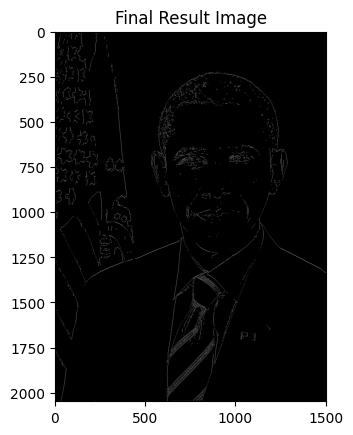

In [ ]:
# upload a new image and try
test_image = image_loader("obama.jpeg")

k_gaussian=5
mu=0
sigma=1
k_sobel=3
low_threshold=0.1
high_threshold=0.5

canny_model = CannyFilter(k_gaussian=k_gaussian,
                          mu=mu,
                          sigma=sigma,
                          k_sobel=k_sobel,
                          low_threshold=low_threshold,
                          high_threshold=high_threshold)

blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges, final_result = canny_model(test_image)

imshow(final_result, title='Final Result Image')

# Reference
- https://ieeexplore.ieee.org/document/4767851
- https://towardsdatascience.com/implement-canny-edge-detection-from-scratch-with-pytorch-a1cccfa58bed
- https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123